In [68]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [70]:
len(words)

32033

In [71]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [72]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0]* block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [73]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [74]:
C = torch.randn((27, 2))

In [75]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [76]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [77]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [78]:
h

tensor([[ 0.3061, -0.6563,  0.4088,  ..., -0.3936,  0.8482,  0.2690],
        [-0.5234, -0.9670, -0.3544,  ..., -0.8532, -0.8032, -0.3093],
        [-0.5483, -0.9953,  0.6328,  ..., -0.8611,  0.9993, -0.4769],
        ...,
        [ 0.9977, -0.6244, -0.9830,  ...,  0.9126,  0.9974,  0.9985],
        [-1.0000, -1.0000, -0.9878,  ..., -0.9786, -0.9290,  0.9679],
        [ 0.9994,  0.4199, -0.9700,  ...,  0.9993,  0.9994,  0.1155]])

In [79]:
h.shape

torch.Size([228146, 100])

In [80]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [81]:
logits = h @ W2 + b2

In [82]:
logits.shape

torch.Size([228146, 27])

In [83]:
coutns = logits.exp()

In [84]:
prob = coutns / coutns.sum(1, keepdim=True)


In [85]:
prob.shape

torch.Size([228146, 27])

In [86]:
# ------ now made respectable :) --------

In [87]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [123]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,20), generator=g).to('cuda')
W1 = torch.randn((60, 200), generator=g).to('cuda')
b1 = torch.randn(200, generator=g).to('cuda')
W2 = torch.randn((200, 27), generator=g).to('cuda')
b2 = torch.randn(27, generator=g).to('cuda')
parameters = [C, W1, b1,W2, b2]

In [124]:
sum(p.nelement() for p in parameters)

18167

In [126]:
for p in parameters:
    p.requires_grad = True

In [127]:
lre = torch.linspace(-3,0, 1000 )
lrs = 10**lre


In [128]:
lri = []
lossi = []
stepi = []

In [129]:

for i in range(150000):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (128,))
    emb = C[Xtr[ix]].to('cuda')
    h = torch.tanh(emb.view(-1, 60) @ W1 + b1).to('cuda')
    logits = (h@W2+b2).to('cuda')
    # loss
    loss = F.cross_entropy(logits,Ytr[ix].to('cuda')).to('cuda')
    # print(loss.item())
    for p in parameters:
        p.grad = None
        p = p.to('cuda')
    loss.backward()
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr* p.grad
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


KeyboardInterrupt: 

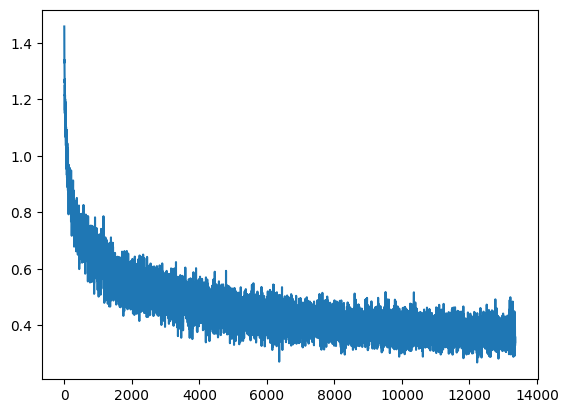

In [130]:
plt.plot(stepi, lossi)

In [136]:
emb = C[Xdev].to('cuda')
h = torch.tanh(emb.view(-1, 60) @ W1 + b1).to('cuda')
logits = (h @ W2 + b2).to('cuda')
loss = F.cross_entropy(logits, Ydev.to('cuda')).to('cuda')
loss

tensor(2.4152, device='cuda:0', grad_fn=<NllLossBackward0>)

In [138]:
emb = C[Xte].to('cuda')
h = torch.tanh(emb.view(-1, 60) @ W1 + b1).to('cuda')
logits = (h @ W2 + b2).to('cuda')
loss = F.cross_entropy(logits, Yte.to('cuda')).to('cuda')
loss

tensor(2.4144, device='cuda:0', grad_fn=<NllLossBackward0>)

In [142]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context]).to('cuda')] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1).to('cuda')
      logits = (h @ W2 + b2).to('cuda')
      probs = F.softmax(logits.to('cuda'), dim=1).to('cuda')
      ix = torch.multinomial(probs.to('cpu'), num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mria.
gryannieep.
niha.
alarethrsekygrie.
caisherielitzell.
jen.
emersenna.
areelyn.
malara.
nyshirelishira.
jayla.
reidy.
panterian.
bennedi.
jamili.
eli.
kayshia.
kyla.
hil.
calynn.


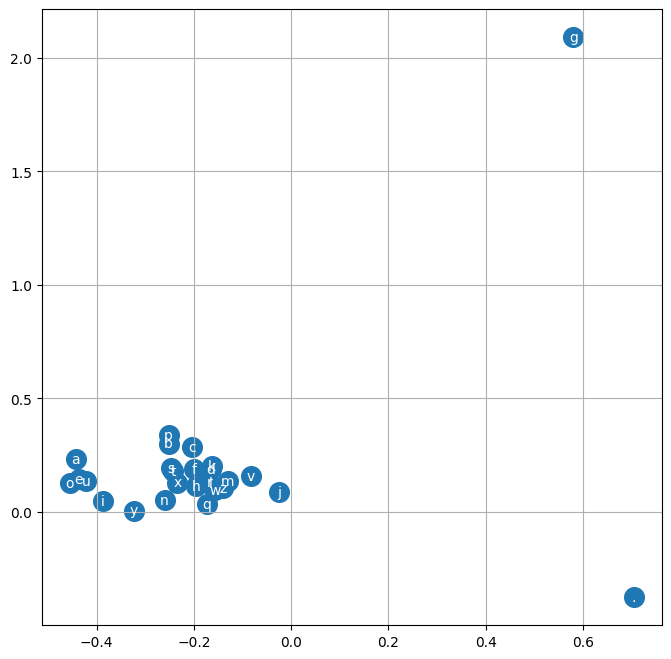

In [100]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')